### Library and Data Import

In [1]:
# Library import
from datetime import datetime
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from prophet import Prophet
from prophet.plot import plot_plotly
rcParams['figure.figsize'] = 10, 6

In [2]:
# Data import
df = pd.read_csv('Dataset/customerbydate.csv', sep = ';')
df = df.rename(columns={'sum':'value'})
df = df.set_index('date')
df.head()

,count
date,
2022-01-01,13
2022-01-02,16
2022-01-03,17
2022-01-04,17
2022-01-05,9


### Data Overview and Preparation

In [3]:
# Data Overview
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
count,365.0,13.556164,3.997286,5.0,11.0,13.0,16.0,30.0


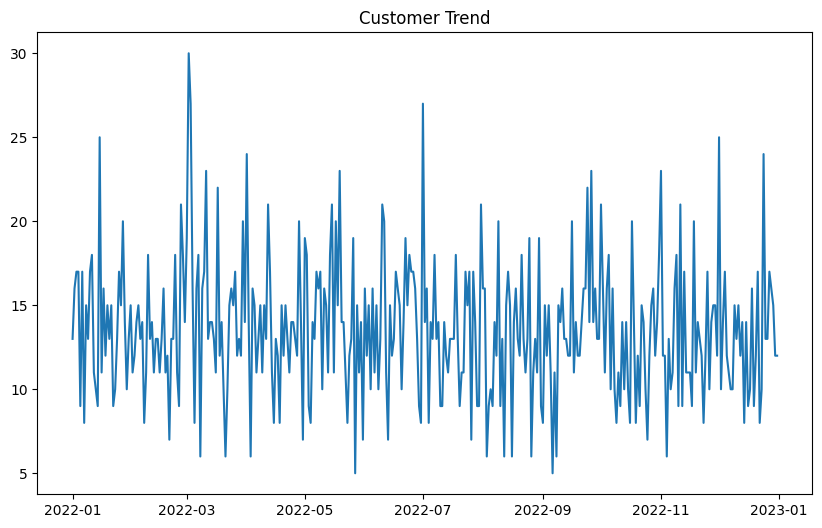

In [4]:
df.index = pd.to_datetime(df.index)
plt.plot(df.index, df['count'])
plt.title('Customer Trend')
plt.show()

In [5]:
#Perform Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['count'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -1.878147e+01
p-value                        2.024207e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.640000e+02
Critical Value (1%)           -3.448443e+00
Critical Value (5%)           -2.869513e+00
Critical Value (10%)          -2.571018e+00
dtype: float64


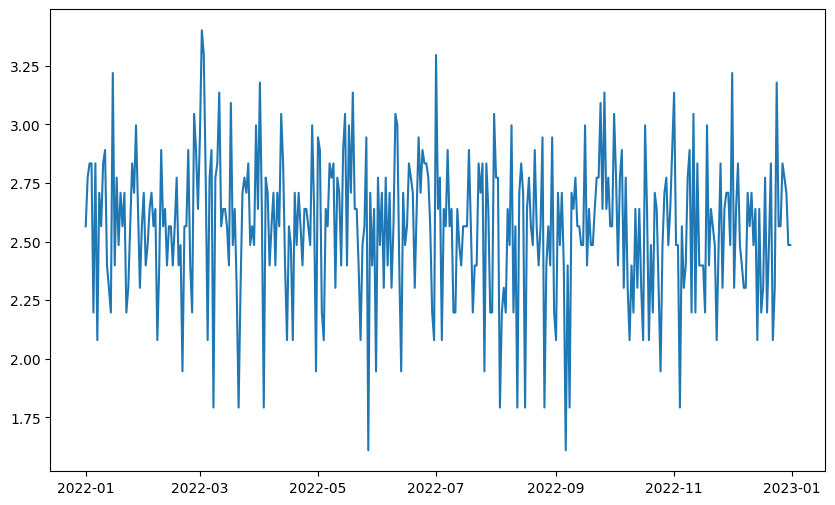

In [6]:
df_logScale = np.log(df)
plt.plot(df_logScale)

In [7]:
#Perform Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_logScale['count'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -19.261078
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


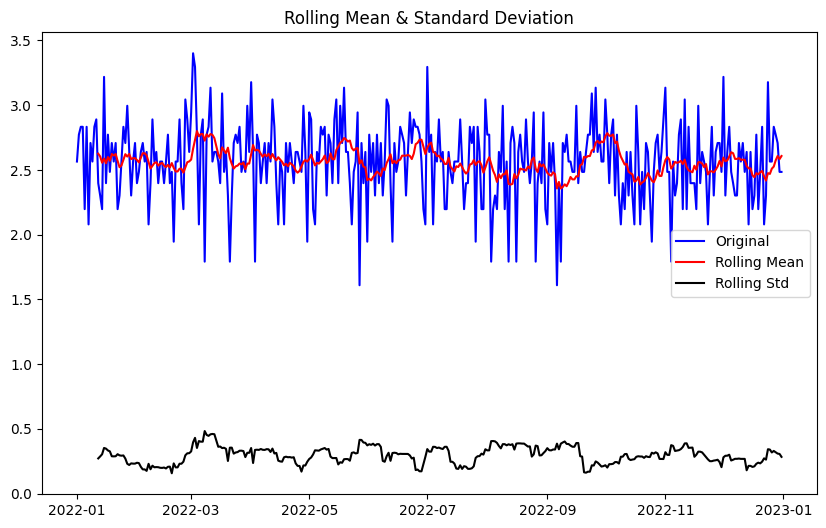

In [8]:
#Determine rolling statistics
movingAverage = df_logScale.rolling(window=12).mean()
movingSTD = df_logScale.rolling(window=12).std()
    
#Plot rolling statistics
orig = plt.plot(df_logScale, color='blue', label='Original')
mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
std = plt.plot(movingSTD, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

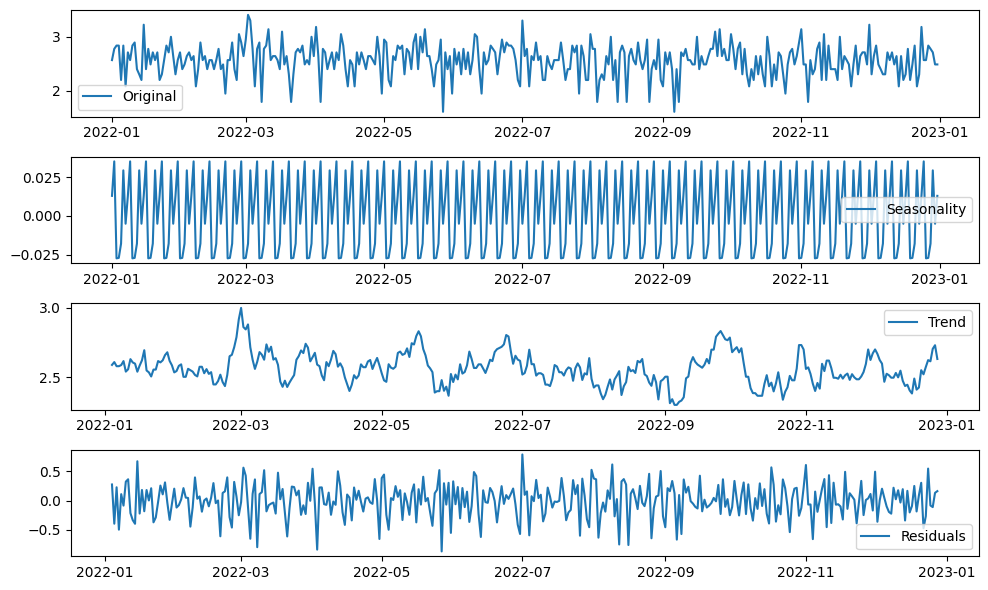

In [9]:
decomposition = seasonal_decompose(df_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)

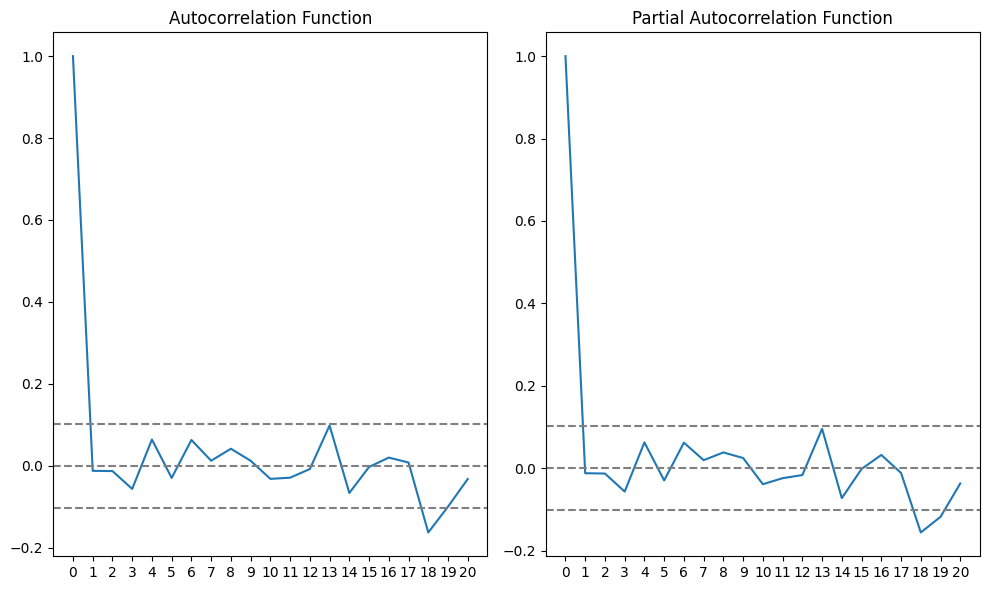

In [10]:
#ACF & PACF plots

lag_acf = acf(df_logScale, nlags=20)
lag_pacf = pacf(df_logScale, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.xticks(range(0, len(lag_acf)))     
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_logScale)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_logScale)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')     

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.xticks(range(0, len(lag_pacf)))
plt.axhline(y=-1.96/np.sqrt(len(df_logScale)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_logScale)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()  

In [11]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

train_data = df_logScale[1:round(len(df_logScale)*0.9)]
test_data = df_logScale[round(len(df_logScale)*0.9):]

p_values = range(0, 10)
d_values = range(0, 2)
q_values = range(0, 2)

best_model = None
best_mse = float('inf')

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            warnings.filterwarnings("ignore")
            try:
                model = ARIMA(train_data, order=order).fit()
                predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
                error = mean_squared_error(test_data, predictions)

                if error < best_mse:
                    best_mse = error
                    best_model = model

            except:
                continue

print("\nBest ARIMA Model:")
print(best_model.summary())


Best ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  327
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -79.007
Date:                Wed, 09 Aug 2023   AIC                            168.014
Time:                        14:50:16   BIC                            186.963
Sample:                    01-02-2022   HQIC                           175.575
                         - 11-24-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5627      0.018    146.190      0.000       2.528       2.597
ar.L1          0.4117      1.779      0.231      0.817      -3.075       3.899
ar.L2         -0.0258      0.062 

In [12]:
model = ARIMA(train_data, order=(2,0,1)).fit()
predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
error = mean_squared_error(test_data, predictions)
rmse = np.sqrt(error)
r2 = r2_score(test_data, np.array(predictions))
print('MSE : ', error)
print('RMSE : ', rmse)
print('R2 Score : ', r2)

MSE :  0.0680807760870716
RMSE :  0.2609229313170301
R2 Score :  0.0013935067565689074


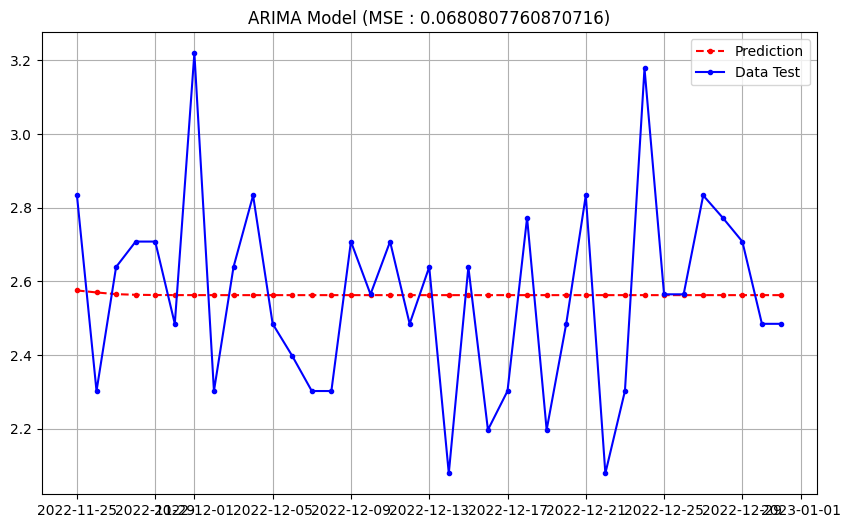

In [13]:
plt.figure(figsize = (10,6))
plt.grid(True)

plt.plot(predictions.index, predictions, color = 'red', marker = '.', linestyle = 'dashed', label = 'Prediction')
plt.plot(test_data.index, test_data, color = 'blue', marker = '.', label = 'Data Test')

plt.title('ARIMA Model (MSE : '  + error.astype(str) + ')')
plt.legend()
plt.show()

In [14]:
p_values = range(0, 15)
d_values = range(0, 2)
q_values = range(0, 2)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)

from itertools import product
best_model = None
best_mse = float('inf')

for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
    order = (p, d, q)
    seasonal_order = (P, D, Q, 7)  # Assuming seasonality is 12, you can change it as per your data

    warnings.filterwarnings("ignore")
    try:
        model = ARIMA(train_data, order=order, seasonal_order=seasonal_order).fit()
        predictions = model.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
        error = mean_squared_error(test_data, predictions)

        if error < best_mse:
            best_mse = error
            best_model = model

    except:
        continue

print("\nBest ARIMA Model:")
print(best_model.summary())



Best ARIMA Model:
                                     SARIMAX Results                                     
Dep. Variable:                             count   No. Observations:                  327
Model:             ARIMA(7, 0, 0)x(0, 0, [1], 7)   Log Likelihood                 -75.146
Date:                           Wed, 09 Aug 2023   AIC                            170.292
Time:                                   15:00:41   BIC                            208.192
Sample:                               01-02-2022   HQIC                           185.415
                                    - 11-24-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5628      0.019    133.222      0.000       2.525       2.601
ar.L1          0.0341   

In [15]:
model_tuning = ARIMA(train_data, order=(7, 0, 0), seasonal_order=(0, 0, 1, 7)).fit()
predictions_tuning = model_tuning.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
error_tuning = mean_squared_error(test_data, predictions_tuning)
rmse_tuning = np.sqrt(error_tuning)
r2_tuning = r2_score(test_data, np.array(predictions_tuning))
print('MSE : ', error_tuning)
print('RMSE : ', rmse_tuning)
print('R2 Score : ', r2_tuning)

MSE :  0.0662217452199237
RMSE :  0.25733586073441783
R2 Score :  0.028661707881355913


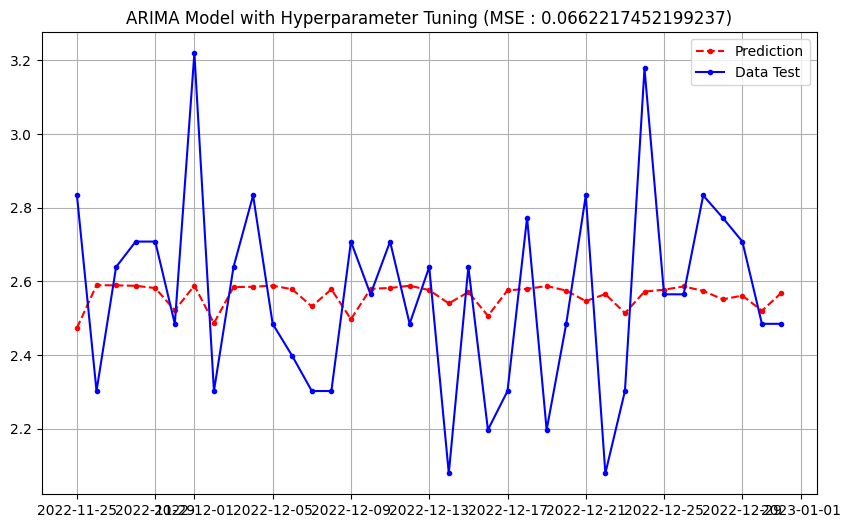

In [16]:
plt.figure(figsize = (10,6))
plt.grid(True)

plt.plot(predictions_tuning.index, predictions_tuning, color = 'red', marker = '.', linestyle = 'dashed', label = 'Prediction')
plt.plot(predictions_tuning.index, test_data['count'], color = 'blue', marker = '.', label = 'Data Test')

plt.title('ARIMA Model with Hyperparameter Tuning (MSE : '  + error_tuning.astype(str) + ')')
plt.legend()
plt.show()

In [17]:
train_data_date = train_data.copy().reset_index().rename(columns={'count':'y', 'date':'ds'})
model_prophet = Prophet()
model_prophet.fit(train_data_date)
future = model_prophet.make_future_dataframe(periods=len(test_data))
forecast = model_prophet.predict(future)
forecast_prophet = forecast.iloc[len(train_data_date):]
predictions_prophet = forecast_prophet['yhat']
error_prophet = mean_squared_error(test_data, predictions_prophet)
rmse_prophet = np.sqrt(error_prophet)
r2_prophet = r2_score(test_data, predictions_prophet)
print('MSE : ', error_prophet)
print('RMSE : ', rmse_prophet)
print('R2 Score : ', r2_prophet)

15:00:44 - cmdstanpy - INFO - Chain [1] start processing
15:00:44 - cmdstanpy - INFO - Chain [1] done processing


MSE :  0.07079395340026841
RMSE :  0.2660713314137177
R2 Score :  -0.03840328520147129


In [18]:
# Initiate the model
baseline_model = Prophet()
train_data_prop = train_data.copy().reset_index().rename(columns = {'date':'ds', 'count':'y'})
# Fit the model on the training dataset
baseline_model.fit(train_data_prop)
future = baseline_model.make_future_dataframe(periods=len(test_data))
forecast = baseline_model.predict(future)
forecast_prophet = forecast.iloc[len(train_data_prop):]
predictions_prophet = forecast_prophet['yhat']
error_prophet = mean_squared_error(test_data, predictions_prophet)
rmse_prophet = np.sqrt(error_prophet)
r2_prophet = r2_score(test_data, predictions_prophet)
print('MSE : ', error_prophet)
print('RMSE : ', rmse_prophet)
print('R2 Score : ', r2_prophet)

15:00:45 - cmdstanpy - INFO - Chain [1] start processing
15:00:45 - cmdstanpy - INFO - Chain [1] done processing


MSE :  0.07079395340026841
RMSE :  0.2660713314137177
R2 Score :  -0.03840328520147129


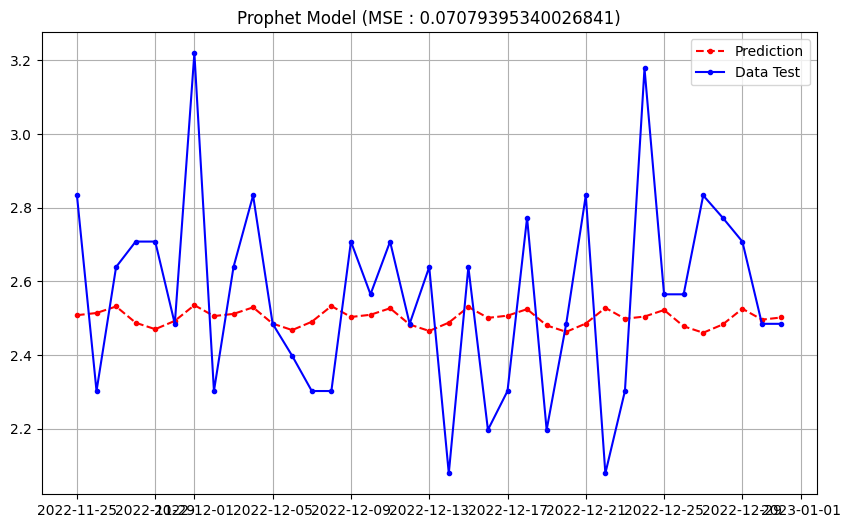

In [19]:
plt.figure(figsize = (10,6))
plt.grid(True)

plt.plot(test_data.index, predictions_prophet, color = 'red', marker = '.', linestyle = 'dashed', label = 'Prediction')
plt.plot(test_data.index, test_data, color = 'blue', marker = '.', label = 'Data Test')

plt.title('Prophet Model (MSE : '  + error_prophet.astype(str) + ')')
plt.legend()
plt.show()

In [25]:
predictions_prophet = pd.DataFrame(predictions_prophet)
predictions_prophet = predictions_prophet.set_index(test_data.index)
result_total_customer = test_data.copy()
result_total_customer['Arima'] = predictions
result_total_customer['Arima Tuning'] = predictions_tuning
result_total_customer['Prophet'] = predictions_prophet
result_total_customer.head()

,count,Arima,Arima Tuning,Prophet
date,,,,
2022-11-25,2.833213,2.415951,2.473741,2.508305
2022-11-26,2.302585,2.656599,2.589686,2.514278
2022-11-27,2.639057,2.476876,2.589294,2.531983
2022-11-28,2.708050,2.520042,2.588029,2.487851
2022-11-29,2.708050,2.424637,2.581892,2.470363


In [31]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=result_total_customer.index, y=result_total_customer['count'], mode='lines', name='Real Data', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=result_total_customer.index, y=result_total_customer['Arima'], mode='lines', name='Arima', line=dict(color='red')))
fig.add_trace(go.Scatter(x=result_total_customer.index, y=result_total_customer['Arima Tuning'], mode='lines', name='Arima With Tuning', line=dict(color='green')))
fig.add_trace(go.Scatter(x=result_total_customer.index, y=result_total_customer['Prophet'], mode='lines', name='Prophet', line=dict(color='orange')))

# Update the layout
fig.update_layout(title='Time Series Model Results for Total Customer Prediction',
                  xaxis_title='Date',
                  yaxis_title='Total Qty',
                  showlegend=True)

# Show the plot
fig.show()

In [20]:
future_prediction = model_tuning.predict(364,395)
future_prediction_value = np.exp(future_prediction)

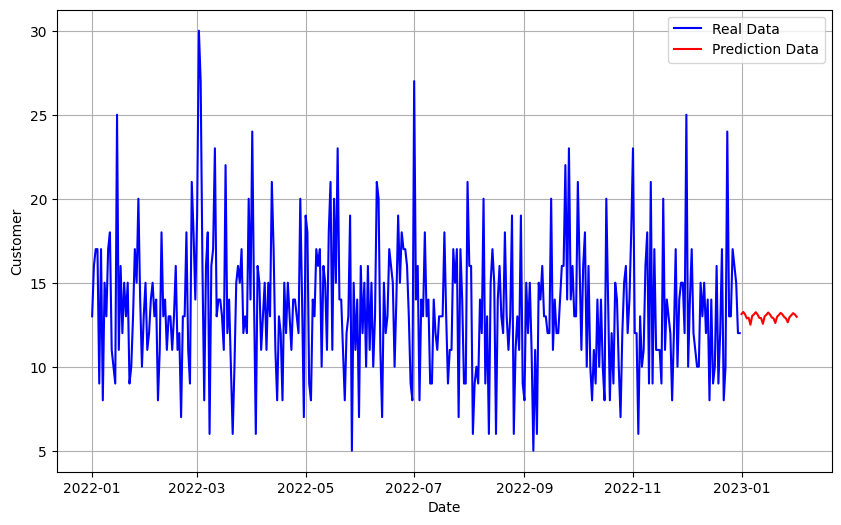

In [21]:
# Plot train and test data

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Customer')
plt.plot(df, 'blue', label = 'Real Data')
plt.plot(future_prediction_value, 'Red', label = 'Prediction Data')
plt.legend()

In [39]:
pred = model_tuning.predict(364,395)
future_prediction_value = np.exp(pred)
future_prediction = pd.DataFrame(future_prediction_value)
prediction_totalcustomer = df[335:]
prediction_totalcustomer = pd.concat([prediction_totalcustomer, future_prediction])

In [41]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add the real data trace
fig.add_trace(go.Scatter(x=prediction_totalcustomer.index, y=prediction_totalcustomer['count'], mode='lines', name='Real Data', line=dict(color='blue')))

# Add the prediction data trace
fig.add_trace(go.Scatter(x=prediction_totalcustomer.index, y=prediction_totalcustomer['predicted_mean'], mode='lines', name='Prediction Data', line=dict(color='red')))

# Update the layout
fig.update_layout(title='Future Prediction of Total Customer Prediction',
                  xaxis_title='Date',
                  yaxis_title='Total Customer',
                  showlegend=True)

# Show the plot
fig.show()